In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
(train_set, train_label), (test_set, test_label) = mnist.load_data()
train_set, train_label = train_set[:20000], train_label[:20000]

In [ ]:
train_set.shape

(20000, 28, 28)

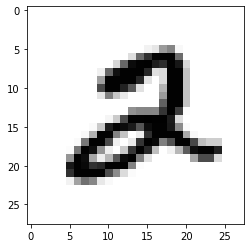

In [ ]:
plt.imshow(train_set[5][:,:], cmap = plt.cm.binary)

In [ ]:
#Reshape the images as a 784d vector
train_set = train_set.reshape(20000,-1)/255

In [ ]:
#Binarising the data for use in Bernoulli
train_set[train_set < 0.5] = 0
train_set[train_set > 0.5] = 1

In [ ]:
train_set.shape

(20000, 784)

##Section 1: Implementing a Multi Dimensional Bernoulli Random Variable


MLE Estimate of theta for MNIST

In [ ]:
theta_MLE = np.mean(train_set, axis = 0, keepdims = True)
theta_MLE.shape

(1, 784)

Visualisation of the MLE Estimate

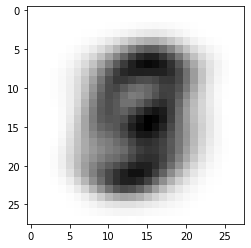

In [ ]:
theta_MLE = theta_MLE.reshape(28,28)*255
plt.imshow(theta_MLE, cmap = plt.cm.binary)

##Section 2: Implementing KMeans

Function to calculate euclidean distances

In [ ]:
def calcSqDistances(X, Kmus):
    return ((-2 * X.dot(Kmus.T) + np.sum(np.multiply(Kmus,Kmus), axis=1).T).T + np.sum(np.multiply(X,X), axis=1)).T

Function to determine Rnk (cluster membership)

In [ ]:
def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis=1)
    return np.eye(sqDmat.shape[1])[m]

Function to recalculate Mus

In [ ]:
def recalcMus(X, Rnk):
    return (np.divide(X.T.dot(Rnk), np.sum(Rnk, axis=0))).T

Function that combines all above code to run Kmeans and outputs the Kmus

In [ ]:
def runKMeans(K):
    X = train_set
    N = 20000
    D = 784

    Kmus = np.zeros((K,D))

    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];

    maxiters = 500;

    for iter in range (maxiters):

        sqDmat = calcSqDistances(X,Kmus);

        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus

        Kmus = recalcMus(X, Rnk)

        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break
        return Kmus

In [ ]:
Kmus_10 = runKMeans(10)
Kmus_20 = runKMeans(20)


In [ ]:
def get_cluster_plot(Kmus):
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(2,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(28,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

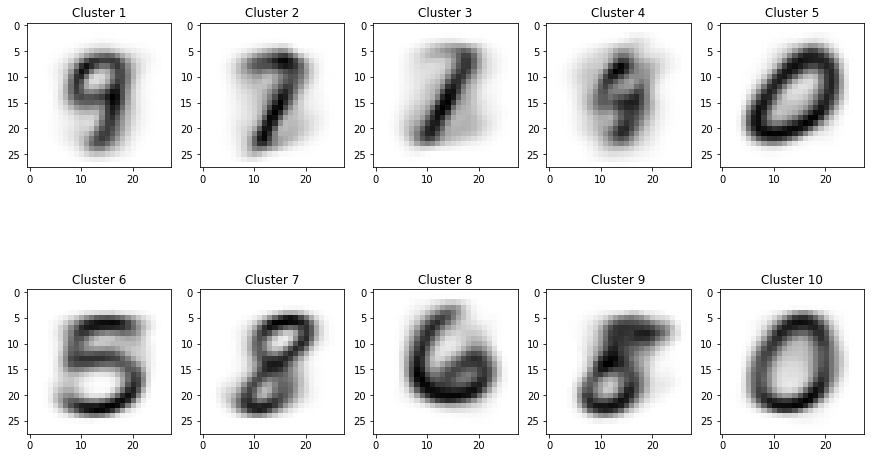

In [ ]:
get_cluster_plot(Kmus_10) #Get cluster representation for K = 10 clusters

IndexError: ignored

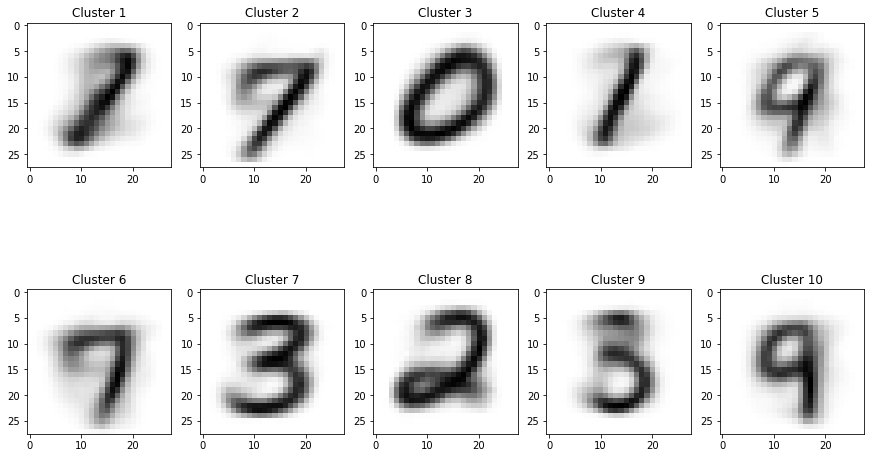

In [ ]:
get_cluster_plot(Kmus_20) #Get cluster representation for K = 20 clusters



```
# This is formatted as code
```

##Section 3: Implementation of a Mixture of Bermoulli Distributions


In [ ]:
def train_EM_MOB(x , pi, theta, K = 10):
    '''
    :input arguments ---> data set, mixture probabilities, initial cluster locations and number of mixtures
    : Implement the EM algorithm for Mixture of Bernoulli random variables
    '''
    N = len(x)
    #Do Up to 100 iterations of EM to set a bound
    max_iters = 500
    for iter in tqdm(range(max_iters)):
        #Create matrix to store the gamma of each cluster
        yik = np.zeros((N,K))
        #Go through each cluster
        for j in range(K):
            #Compute E step for all clusters
            matrix1 = theta[j]**x
            matrix2 = (1 - theta[j])**(1 - x)
            matrix = matrix1 * matrix2
            #Calculate the value for one cluster
            yik[:,j] = np.prod(matrix, axis = 1) * pi[j]
        #Calculate M step using yik from E step
        yik = np.divide(yik, np.sum(yik, axis = 1, keepdims = True))
        #Find new parameters for the next step of EM
        pi_new = np.sum(yik, axis = 0)/N
        theta_new = np.divide(yik.T @ x, np.sum(yik, axis = 0, keepdims = True).T)
        #Terminate if there is no major changes
        if np.linalg.norm(theta_new - theta) < 0.001:
            break
        pi,theta = pi_new, theta_new
    #Return the pi and theta after the algorithm finished in order to plot each cluster
    return pi_new, theta_new


In [ ]:
train = train_set
#Initialise the P(z = k) = $$\pi_k$$
pi = np.random.randint(1,3,10)
pi = pi/np.sum(pi)
#Initialise theta
theta = np.random.randint(2,5,(10,784))
theta = 1/theta
#First try out with a small dataset
pi_new, theta_new = train_EM_MOB(train[:1000] , pi , theta)
#After ensuring it works as expected, run on full dataset
#pi_new, theta_new = train_EM_MOB(train , pi, theta)

 11%|█         | 56/500 [00:16<02:08,  3.45it/s]


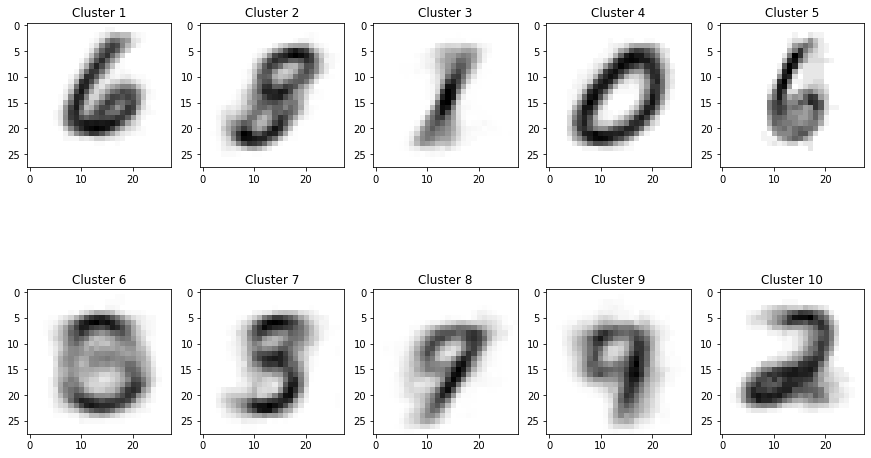

In [ ]:
get_cluster_plot(theta_new) #Get the cluster representation for a mixture model with 10 mixtures

## Section 4: Implementation of PCA

Define all the needed functions. Notice that viewcolumn is reshaping as 28x28 instead of 60x60 like it was in HW4, that's because these images are 28x28 pixels.

In [ ]:
def eigsort(V, eigvals):

    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)

    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape([28, 28], order='F'), cmap=plt.get_cmap('gray'))


def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

Cut down the dataset from 20,000 images to just 400 to make PCA run faster.

(400, 784)

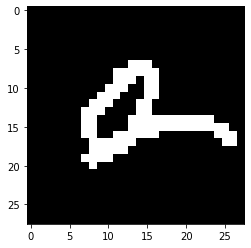

In [ ]:
viewcolumn(train_set[4])
tr_set, tr_label = train_set[:400], train_label[:400]
tr_set.shape

In [ ]:
mnist = tr_set.reshape(400, -1)

In [ ]:
mnist = mnist.T
mnist.shape

(784, 400)

Calculate the mean number from the 400 images.

(784, 1)

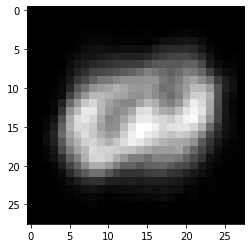

In [ ]:
meannum = np.mean(mnist, axis = 1, keepdims = True)
viewcolumn(meannum)
meannum.shape

Mean-subtract the data

In [ ]:
A = mnist - meannum
A.shape

(784, 400)

Calculate the eigenvectors from the covariance matrix.

In [ ]:
eigvals, Vold = np.linalg.eig(A.T.dot(A))

Sort the eigenvectors by their eigenvalues.

In [ ]:
V, D = eigsort(Vold, eigvals)

Multiply the mean-subtracted data by the sorted eigenvectors and then normalize it.

In [ ]:
U = A@V

In [ ]:
from sklearn.preprocessing import normalize
U = normc(U) #Just to ensure that directions we find is unit vector
print(U.shape)

(784, 400)


Calculate the principal components for the 4th image in the training set.

In [ ]:
c = U.T.dot(mnist[:,4][:, np.newaxis] - meannum)

In [ ]:
c.shape

(400, 1)

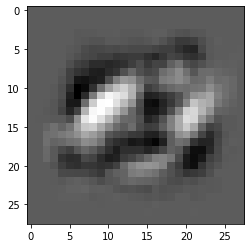

In [ ]:
viewcolumn(U[:, 4])

Reconstruct the 4th image using all 400 of the principal components. We have 400 principal components because there are 400 images.

(784, 1)


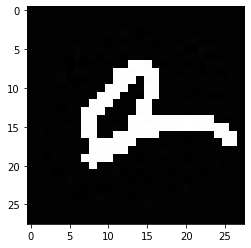

In [ ]:
k = 400 #reconstruction using all 400 principal components
Zhat = U[:, :k] @ c[:k, :] + meannum
print(Zhat.shape)
viewcolumn(Zhat)
#viewcolumn(mnist[:, 4])

Reconstruct with half of the principal components.

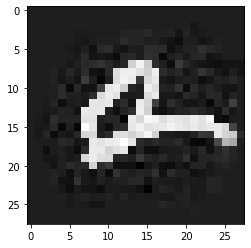

In [ ]:
k = 200 #reconstruction using 200 principal components
Zhat = U[:, :k] @ c[:k, :] + meannum
viewcolumn(Zhat)

Reconstruct with just 10 principal components.

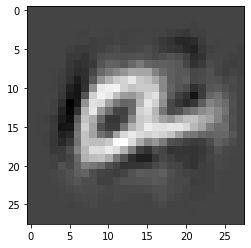

In [ ]:
k = 10 #reconstruction using 10 principal components
Zhat = U[:, :k] @ c[:k, :] + meannum
viewcolumn(Zhat)

Reconstructing an image that wasn't in the 400 images used for PCA

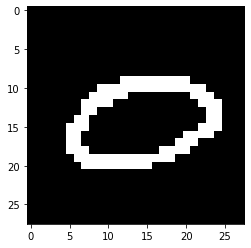

In [ ]:
viewcolumn(train_set[1000])

In [ ]:
c = U.T.dot(train_set[1000,:][:, np.newaxis] - meannum)

As we can see below, we were able to reconstruct the 1000th image in the dataset fairly well even though it wasn't included in our PCA.

(784, 1)


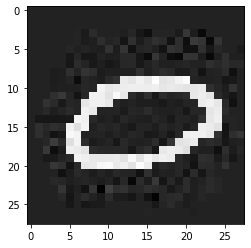

In [ ]:
k = 400 #reconstruction using all 400 principal components
Zhat = U[:, :k] @ c[:k, :] + meannum
print(Zhat.shape)
viewcolumn(Zhat)
#viewcolumn(mnist[:, 4])

###PCA with all the data, using the transpose trick

First, calculate the mean of the data and don't reshape it so that the dimensions of the mean is 1x784

(1, 784)

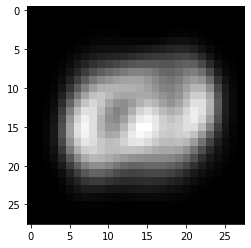

In [ ]:
meanNum = np.mean(train_set, axis = 0, keepdims = True)
viewcolumn(meanNum)
meanNum.shape

Next, zero mean the data

In [ ]:
A = train_set - meanNum
print(A.shape)
A

(20000, 784)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Use the transpose trick to calculate the covariance matrix of the data and find its eigenvectors. Transpose trick: instead of computing A\*A(T) which would be 20,000x20,000, compute A(T)\*A which is 784x784

In [ ]:
eigvals, Vold = np.linalg.eig(A.T.dot(A))

Then sort the eigenvectors in order of their eigenvalue

In [ ]:
V, D = eigsort(Vold, eigvals)
print("Matrix of V\n", V)


Matrix of V
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Computer U by multiplying the zero-meaned data by the sorted eigenvectors.

In [ ]:
U = A@V
U
U.shape

(20000, 784)

Normalize U

In [ ]:
U = normc(U)
U

array([[-1.45183380e-03,  4.44940032e-03, -7.46018124e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.33388736e-02,  4.87426478e-03, -8.45184218e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.14749449e-05, -5.47140256e-03,  4.79369288e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 7.93191132e-03,  1.49839393e-03,  4.52473534e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.95560210e-03, -2.51887265e-03, -1.33545578e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.59033623e-03,  9.15622322e-03, -9.34249058e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Reconstruct the 4th image in the training set by calculating the principal components.

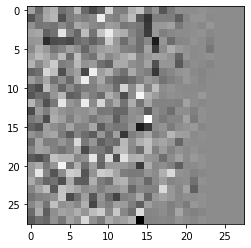

In [ ]:
viewcolumn(U[4,:])
U_reshape = U.reshape(U.shape[1],-1)
train_reshape = train_set[4:5,:].reshape(train_set[4:5,:].shape[1],-1)
mean_reshape = meanNum.reshape(meanNum.shape[1],-1)
c = U_reshape.T.dot(train_reshape[:,0] - mean_reshape[:,0])

Original 4th image:

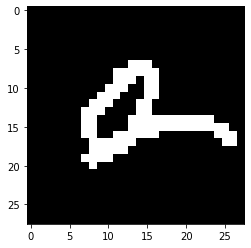

In [ ]:
viewcolumn(train_set[4])

Reconstructed 4th image using all 20,000 principal components:

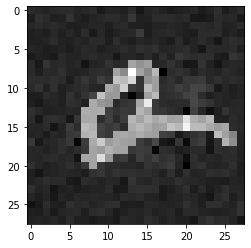

In [ ]:
k=20000
Zhat = U_reshape[:, :k] @ c[:k] + meanNum
viewcolumn(Zhat)

Using 10,000 principal components:

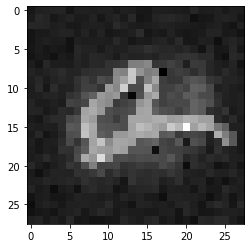

In [ ]:
k=10000
Zhat = U_reshape[:, :k] @ c[:k] + meanNum
viewcolumn(Zhat)

Using just 1,000

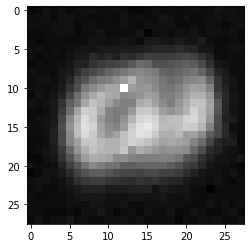

In [ ]:
k=1000
Zhat = U_reshape[:, :k] @ c[:k] + meanNum
viewcolumn(Zhat)